In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Numerical Differentiation

Take a function $f:\mathbb{R} \rightarrow \mathbb{R}$ and a point $x_0 \in \mathbb{R}$. The derivative of $f$ at $x_0$ is defined as

$$
f'(x_0) = \lim_{h \rightarrow 0} \frac{f(x_0 + h) - f(x_0)}{h}.
$$

Numerical differentiation uses a finite value of $h$ to approximate the derivative. The simplest method is to use a *forward difference*:

$$
f'(x_0) \approx \frac{f(x_0 + h) - f(x_0)}{h}.
$$

Let's write code that implements this approximation.
We will use this as an excuse to learn about *higher-order functions* in Python.
These are functions that take other functions as arguments and return functions as results.
The programming paradigm that uses higher-order functions is called *functional programming* or *meta-programming*.

Here it is:

In [3]:
def make_numerical_grad(f, h=1e-4):
    """Return a function that evaluates the derivative of f at any point."""
    def grad(x):
        return (f(x + h) - f(x)) / h
    return grad

Here is how to use this:

In [8]:
f = lambda x: x**3
df = make_numerical_grad(f)
type(df)

function

Let's plot it:

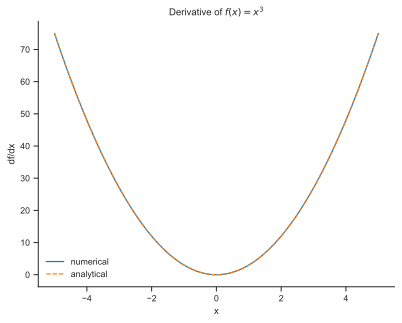

In [13]:
fig, ax = plt.subplots()
x = np.linspace(-5, 5, 100)
ax.plot(x, df(x), label='numerical')
ax.plot(x, 3*x**2, '--', label='analytical')
ax.legend(loc='best', frameon=False)
ax.set(xlabel='x', ylabel='df/dx', title='Derivative of $f(x)=x^3$')
sns.despine();

Let's now move to multivariate functions.
Take a function $f:\mathbb{R}^n \rightarrow \mathbb{R}$ and a point $\mathbf{x}_0 \in \mathbb{R}^n$. The derivative of $f$ at $\mathbf{x}_0$ is defined as the column vector:

$$
\nabla f(\mathbf{x}_0) = \left[ \partial_1 f(\mathbf{x}_0), \ldots, \partial_n f(\mathbf{x}_0) \right]^T
$$

where

$$
\partial_i f(\mathbf{x}_0) = \lim_{h \rightarrow 0} \frac{f(\mathbf{x}_0 + h \mathbf{e}_i) - f(\mathbf{x}_0)}{h}
$$

Notice that our notation is slightly different from the classical notation used in math textbooks.
We write $\partial_i f$ instead of $\frac{\partial f}{\partial x_i}$.
When we write $\partial_i f$ we mean the partial derivative of the function $f$ with respect to the $i$-th argument.
This notation saves us quite a bit of typing.

Let's write a function that computes this derivative using numerical differentiation.

In [35]:
def make_numerical_grad_mv(f, h=1e-4):
    """Return a function that evaluates the derivative of a multivariate f at any point."""
    def grad(x):
        grad = np.zeros_like(x)
        fx =  f(x)
        for i in range(len(x)):
            x_plus_h = x.copy()
            x_plus_h[i] += h
            grad[i] = (f(x_plus_h) - fx) / h
        return grad
    return grad

Let's test it with:

$$
f(x) = x_1^3 + x_2^2 + x_3^4
$$

which has a gradient:

$$
\nabla f(\mathbf{x}) = \left[ 3 x_1^2, 2 x_2, 4 x_3^3 \right]^T.
$$


In [36]:
def f(x):
    return x[0] ** 3 + x[1] ** 2 + x[2] ** 4

gf = make_numerical_grad_mv(f)

x = np.array([1.0, 1.0, 1.0])

gf(x)

array([3.00030001, 2.0001    , 4.00060004])

It looks like it works!

Okay, now let's talk about the problems of numerical differentiation and why we should not use it in practice.
The first problem is accuracy and the second problem is speed.

Let's talk about accuracy first.
The accuracy of numerical differentiation depends on the value of $h$.
If $h$ is too small, then the approximation is accurate, but the computation of $f(x_0 + h)$ is inaccurate due to round-off errors.
If $h$ is too large, then the approximation is inaccurate.
There is a trade-off between these two sources of error.
The optimal value of $h$ depends on the function $f$ and the point $x_0$.
There is no way to know the optimal value of $h$ in advance.
Let's demonstrate this with an example.

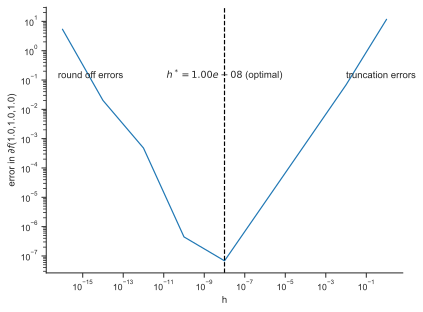

In [37]:
hs = np.logspace(-16, 0, 9)
errors = []
for h in hs:
    gf = make_numerical_grad_mv(f, h=h)
    errors.append(np.linalg.norm(gf(x) - np.array([3, 2, 4])))

fig, ax = plt.subplots()
ax.plot(hs, errors)
optimal_h = hs[np.argmin(errors)]
ax.axvline(optimal_h, linestyle='--', color='k')
ax.text(optimal_h, 1e-1, f'$h^*={optimal_h:.2e}$ (optimal)', ha='center', va='bottom')
ax.text(1e-13, 1e-1, 'round off errors', ha='right', va='bottom')
ax.text(1e-2, 1e-1, 'truncation errors', ha='left', va='bottom')
ax.set(xlabel='h', ylabel=f'error in $\partial f$({x[0]},{x[1]},{x[2]})', xscale='log', yscale='log')
sns.despine();

The second problem is speed.
To evaluate the gradient we need to evaluate the function $n+1$ times.
This gets out of control very quickly in machine learning applications.
Imagine having a neural network with a million parameters and that you want to find the gradient of the loss function with respect to all the parameters.
You would need to evaluate the loss function a million times plus one for each iteration of gradient descent.
This is clearly a really bad idea.